Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
import zipfile
from zipfile import ZipFile
from google.colab import files
import os
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# specify the path of the ZIP archive you want to extract
zip_file_path = "/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip"

# create a ZipFile object
zip_obj = zipfile.ZipFile(zip_file_path)

# extract all the files and directories from the archive to the current working directory
zip_obj.extractall()

# close the ZipFile object
zip_obj.close()

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Checking the current size of image
img_path = r'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg'

# open the image using PIL
img = Image.open(img_path)

# get the dimensions of the image
width, height = img.size

# print the dimensions of the image
print(f"The dimensions of the image are {width}x{height} pixels.")

The dimensions of the image are 600x450 pixels.


Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    seed=123
)

Found 1795 images belonging to 9 classes.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=123
)

Found 444 images belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_indices.keys()
print(class_names)

num_classes = len(class_names)

dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

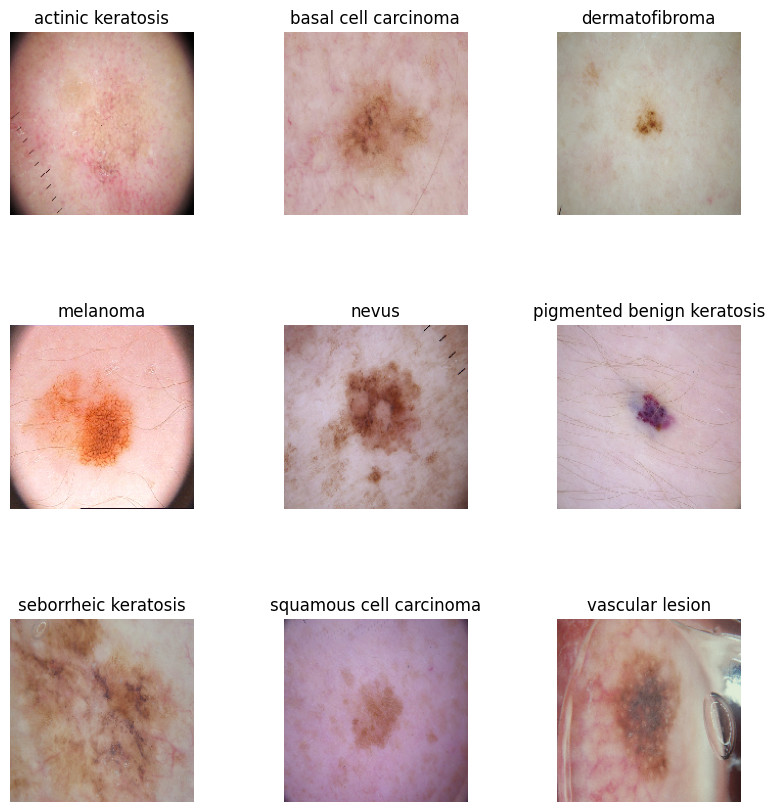

In [11]:
import matplotlib.pyplot as plt

# Get the class names and their integer labels
class_names = list(train_ds.class_indices.keys())
class_labels = train_ds.class_indices

# Create a dictionary to store one image for each class
one_image_per_class = {}

# Loop through the data generator and extract one image for each class
for label in class_labels.values():
    x, _ = train_ds.next()
    while not label in _.argmax(axis=-1):
        x, _ = train_ds.next()
    one_image_per_class[label] = x[_.argmax(axis=-1)[0]]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.6)

for i in range(9):
    img, label = next(train_ds)
    axs[i // 3, i % 3].imshow(img[0])
    axs[i // 3, i % 3].set_title(list(class_labels.keys())[i])
    axs[i // 3, i % 3].axis('off')

plt.show()


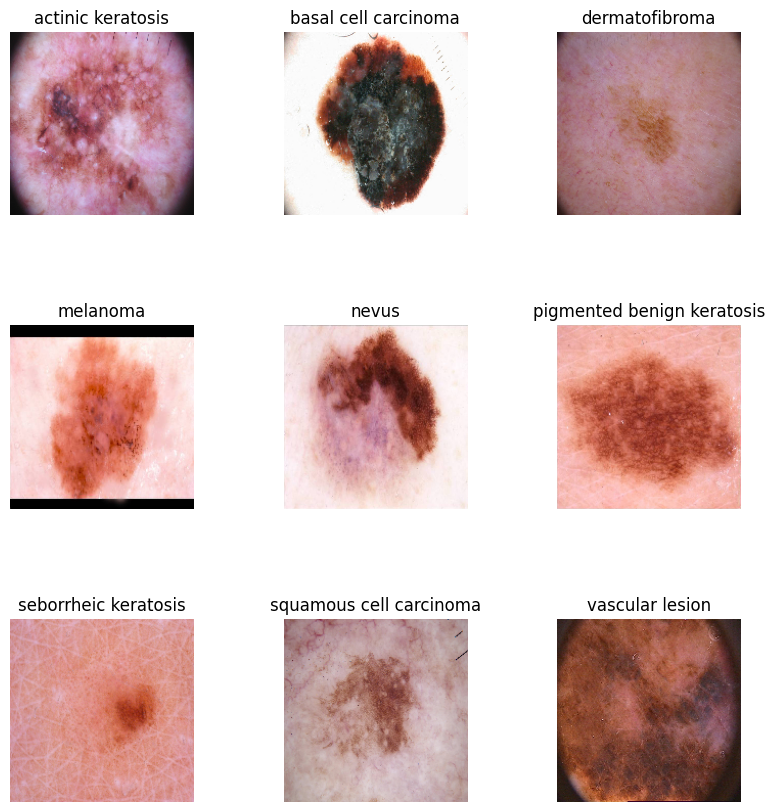

In [12]:
## Visualizing from validation set
# visualize a few images for each class
one_image_per_class = {}

for label in class_labels.values():
    x, _ = val_ds.next()
    while not label in _.argmax(axis=-1):
        x, _ = val_ds.next()
    one_image_per_class[label] = x[_.argmax(axis=-1)[0]]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.6)

for i in range(9):
    img, label = next(val_ds)
    axs[i // 3, i % 3].imshow(img[0])
    axs[i // 3, i % 3].set_title(list(class_labels.keys())[i])
    axs[i // 3, i % 3].axis('off')

plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE


# train_ds = tf.data.Dataset.from_generator(
#     lambda: train_ds,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([None, 180, 180, 3], [None, num_classes])
# )

# val_ds = tf.data.Dataset.from_generator(
#     lambda: val_ds,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([None, 180, 180, 3], [None, num_classes])
# )

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential()

model.add(Conv2D(filters=75 , kernel_size=(3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,3)))
model.add(MaxPool2D(pool_size=(2,2), strides = 2 , padding = 'same'))

model.add(Conv2D(filters=50, kernel_size=(3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2 , padding = 'same'))

model.add(Conv2D(filters=25, kernel_size=(3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 9 , activation = 'softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 75)      2100      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 50)        33800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 50)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 25)        11275     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 25)       0

### Train the model

In [17]:
%%time

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 52s 690ms/step - loss: 2.1628 - accuracy: 0.1939 - val_loss: 2.0287 - val_accuracy: 0.1689
Epoch 2/20
57/57 [==============================] - 40s 700ms/step - loss: 2.0373 - accuracy: 0.2178 - val_loss: 1.9850 - val_accuracy: 0.1802
Epoch 3/20
57/57 [==============================] - 40s 713ms/step - loss: 1.8134 - accuracy: 0.3627 - val_loss: 1.9741 - val_accuracy: 0.3221
Epoch 4/20
57/57 [==============================] - 40s 705ms/step - loss: 1.6137 - accuracy: 0.4290 - val_loss: 2.0290 - val_accuracy: 0.3941
Epoch 5/20
57/57 [==============================] - 40s 700ms/step - loss: 1.4457 - accuracy: 0.4981 - val_loss: 1.8708 - val_accuracy: 0.4054
Epoch 6/20
57/57 [==============================] - 37s 648ms/step - loss: 1.3624 - accuracy: 0.5175 - val_loss: 2.1260 - val_accuracy: 0.3896
Epoch 7/20
57/57 [==============================] - 40s 706ms/step - loss: 1.2726 - accuracy: 0.5409 - val_loss: 2.3171 - val_accuracy: 0.4032

### Visualizing training results

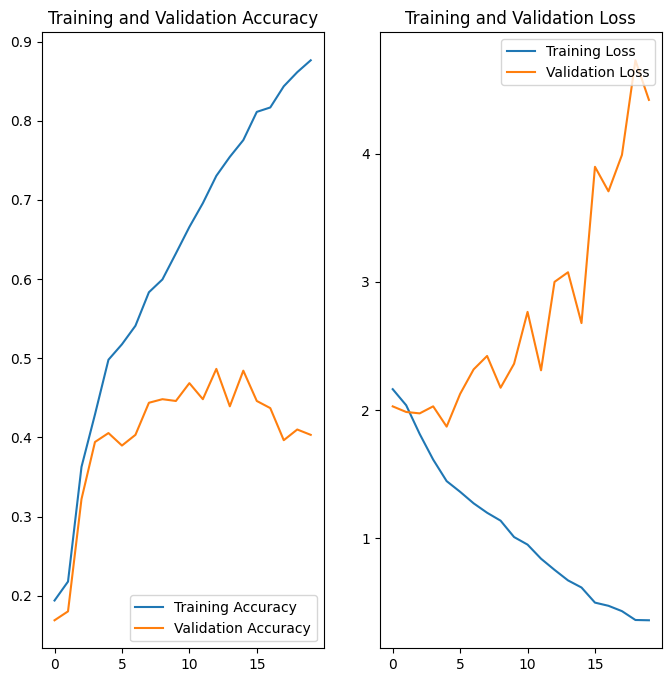

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- I observe the model is being underfit as the training accuracy increases the val accuracy decreases
- Training and val loss both are going in opposite directions
- Perphas models seems to be not learning well. May be I should improve the feature extraction and some more layer for better learning

### Write your findings here

In [11]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_ds = train_datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    seed=123
)

val_ds = train_datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=123
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


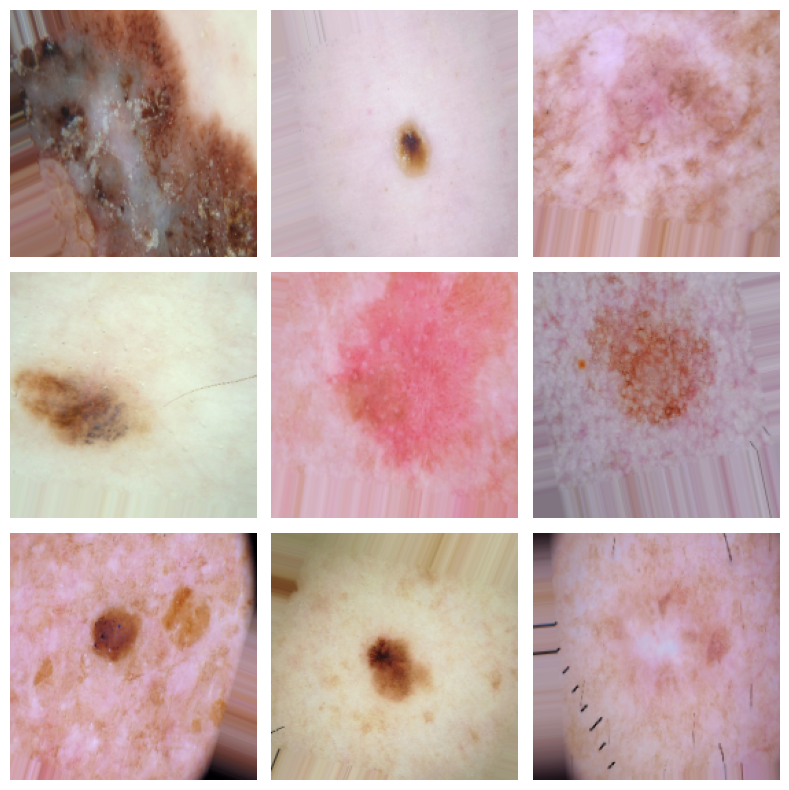

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Generate a batch of augmented images and labels
x_batch, y_batch = train_ds.next()

# Visualize the first 9 images in the batch
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    axs[i].imshow(x_batch[i])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.Sequential([
# First Convolutional Layer with 32 filters and kernel size of 3x3, and ReLU activation
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(180, 180, 3)),
    
    # Second Convolutional Layer with 64 filters and kernel size of 3x3, and ReLU activation
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    
    # Maxpooling Layer with pool size of 2x2
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Dropout Layer with rate of 0.25
    tf.keras.layers.Dropout(rate=0.25),
    
    # Flatten Layer to convert 2D input to 1D
    tf.keras.layers.Flatten(),
    
    # Dense Layer with 128 units and ReLU activation
    tf.keras.layers.Dense(units=128, activation='relu'),
    
    # Batch Normalization Layer
    tf.keras.layers.BatchNormalization(),
    
    # Dropout Layer with rate of 0.5
    tf.keras.layers.Dropout(rate=0.5),
    
    # Output Dense Layer with number of units equal to the number of classes and Softmax activation
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
])



### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 88, 88, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 88, 88, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 495616)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               63438976  
                                                      

### Training the model

In [23]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 57s 945ms/step - loss: 2.0941 - accuracy: 0.3047 - val_loss: 14.4136 - val_accuracy: 0.1689
Epoch 2/20
57/57 [==============================] - 63s 1s/step - loss: 1.7324 - accuracy: 0.4329 - val_loss: 13.4546 - val_accuracy: 0.1622
Epoch 3/20
57/57 [==============================] - 53s 927ms/step - loss: 1.6712 - accuracy: 0.4462 - val_loss: 5.4703 - val_accuracy: 0.1712
Epoch 4/20
57/57 [==============================] - 52s 916ms/step - loss: 1.6461 - accuracy: 0.4334 - val_loss: 8.0785 - val_accuracy: 0.0608
Epoch 5/20
57/57 [==============================] - 52s 919ms/step - loss: 1.5765 - accuracy: 0.4724 - val_loss: 2.3122 - val_accuracy: 0.2883
Epoch 6/20
57/57 [==============================] - 52s 917ms/step - loss: 1.5733 - accuracy: 0.4669 - val_loss: 2.8374 - val_accuracy: 0.2635
Epoch 7/20
57/57 [==============================] - 52s 920ms/step - loss: 1.5203 - accuracy: 0.4813 - val_loss: 2.8551 - val_accuracy: 0.2703


### Visualizing the results

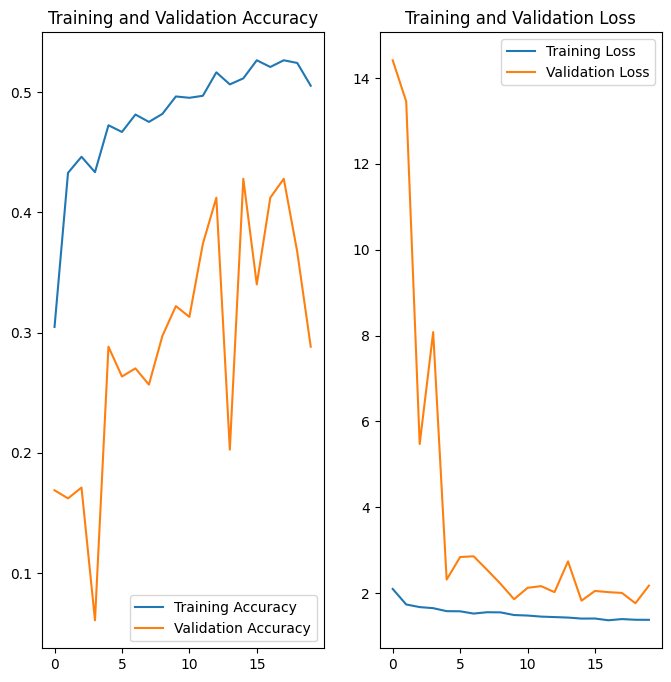

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

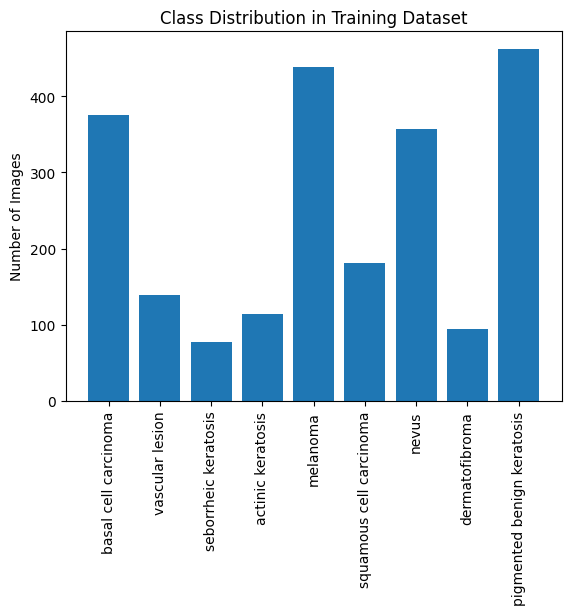

In [12]:
## Your code goes here.

train_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

# Count the number of images in each class
class_counts = {}
for subdir in os.listdir(train_dir):
    class_counts[subdir] = len(os.listdir(os.path.join(train_dir, subdir)))

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [14]:
%%time
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=6)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD61C832490>: 100%|██████████| 500/500 [00:38<00:00, 12.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD61C7E33A0>: 100%|██████████| 500/500 [00:40<00:00, 12.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD61EA283A0>: 100%|██████████| 500/500 [00:28<00:00, 17.45 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FD61C790BB0>: 100%|██████████| 500/500 [02:41<00:00,  3.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD61C7BDF10>: 100%|██████████| 500/500 [02:40<00:00,  3.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD61C754250>: 100%|██████████| 500/500 [00:27<00:00, 17.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD61C78C5B0>: 100%|██████████| 500/500 [01:12<00:00,  6.92 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD61EA28430>: 100%|██████████| 500/500 [00:27<00:00, 18.08 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD61C80EF70>: 100%|██████████| 500/500 [00:28<00:00, 17.55 Samples/s]

CPU times: user 15min 37s, sys: 11.4 s, total: 15min 48s
Wall time: 9min 46s


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [15]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [16]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024582.jpg_fac40a30-f31b-441e-9d85-900613c95745.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031063.jpg_dd69ae35-393e-4473-8f68-8244a5fedfe1.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024515.jpg_dbbcf1f4-7aab-4aed-94d1-c830095ac2bf.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028739.jpg_a0ff5107-e842-4dbc-88dd-6c78816bb8b5.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028687.jpg_03329a08-2471-44db-89df-a8e9a8a84db3.jpg',
 '/content/Skin

In [17]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [18]:
path_list_new = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/*/output'
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [19]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2.append(df2)


<ipython-input-19-f4358e77e180>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df2.append(df2)


In [20]:
new_df['Label'].value_counts()

basal cell carcinoma          1000
vascular lesion               1000
seborrheic keratosis          1000
actinic keratosis             1000
melanoma                      1000
squamous cell carcinoma       1000
nevus                         1000
dermatofibroma                1000
pigmented benign keratosis    1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [21]:
## removing the additional images from the file path
for dir_path in glob(os.path.join(data_dir_train, '*')):
  # Loop over the files in the directory
  for file_name in os.listdir(dir_path):
      
      # Check if the path is a file (not a directory)
      file_path = os.path.join(dir_path, file_name)
      if os.path.isfile(file_path):
          
          # Delete the file
          os.remove(file_path)

In [22]:
source_dir_list = glob(os.path.join(data_dir_train, '*','output'))
dist_dir_list = glob(os.path.join(data_dir_train, '*'))

## Moving files from output folder to the current train folder
for source_dir, dest_dir in zip(source_dir_list, dist_dir_list):
  # print(source_dir, dest_dir)
  # Get list of files in source directory
  file_list = os.listdir(source_dir)

  # Iterate through all files in source directory and move them to destination directory
  for file_name in file_list:
      # Get full path of file in source directory
      src_file = os.path.join(source_dir, file_name)
      # Get full path of file in destination directory
      dest_file = os.path.join(dest_dir, file_name)
      # Move file from source directory to destination directory
      shutil.move(src_file, dest_file)

## Deleting all the source directory
for folder in source_dir_list:
  try:
    os.rmdir(folder)
    print(f"{folder} has been deleted.")
  except OSError as e:
        print(f"Error: {folder} - {e.strerror}.")

/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imagi

#### **Todo**: Train the model on the data created using Augmentor

In [23]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [24]:
data_dir_train= '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [26]:
## your code goes here
model = tf.keras.Sequential([
# First Convolutional Layer with 32 filters and kernel size of 3x3, and ReLU activation
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(180, 180, 3)),
    
    # Second Convolutional Layer with 64 filters and kernel size of 3x3, and ReLU activation
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    
    # Maxpooling Layer with pool size of 2x2
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Dropout Layer with rate of 0.25
    tf.keras.layers.Dropout(rate=0.25),
    
    # Flatten Layer to convert 2D input to 1D
    tf.keras.layers.Flatten(),
    
    # Dense Layer with 128 units and ReLU activation
    tf.keras.layers.Dense(units=128, activation='relu'),
    
    # Batch Normalization Layer
    tf.keras.layers.BatchNormalization(),
    
    # Dropout Layer with rate of 0.5
    tf.keras.layers.Dropout(rate=0.5),
    
    # Output Dense Layer with number of units equal to the number of classes and Softmax activation
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
])



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [27]:
## your code goes here
model.compile(optimizer='adam',
              # loss='categorical_crossentropy',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 88, 64)        0         
                                                                 
 flatten (Flatten)           (None, 495616)            0         
                                                                 
 dense (Dense)               (None, 128)               63438976  
                                                        

#### **Todo:**  Train your model

In [28]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


113/113 [==============================] - 38s 199ms/step - loss: 2.0072 - accuracy: 0.2839 - val_loss: 4.6965 - val_accuracy: 0.1267
Epoch 2/30
113/113 [==============================] - 16s 138ms/step - loss: 1.6830 - accuracy: 0.3833 - val_loss: 1.8970 - val_accuracy: 0.3378
Epoch 3/30
113/113 [==============================] - 16s 138ms/step - loss: 1.5505 - accuracy: 0.4319 - val_loss: 2.0194 - val_accuracy: 0.3122
Epoch 4/30
113/113 [==============================] - 17s 145ms/step - loss: 1.5479 - accuracy: 0.4347 - val_loss: 3.7557 - val_accuracy: 0.1967
Epoch 5/30
113/113 [==============================] - 17s 147ms/step - loss: 1.4840 - accuracy: 0.4675 - val_loss: 1.8340 - val_accuracy: 0.4189
Epoch 6/30
113/113 [==============================] - 17s 139ms/step - loss: 1.3834 - accuracy: 0.5033 - val_loss: 1.5291 - val_accuracy: 0.4289
Epoch 7/30
113/113 [==============================] - 16s 136ms/step - loss: 1.2699 - accuracy: 0.5442 - val_loss: 2.3413 - val_accuracy: 0.4

#### **Todo:**  Visualize the model results

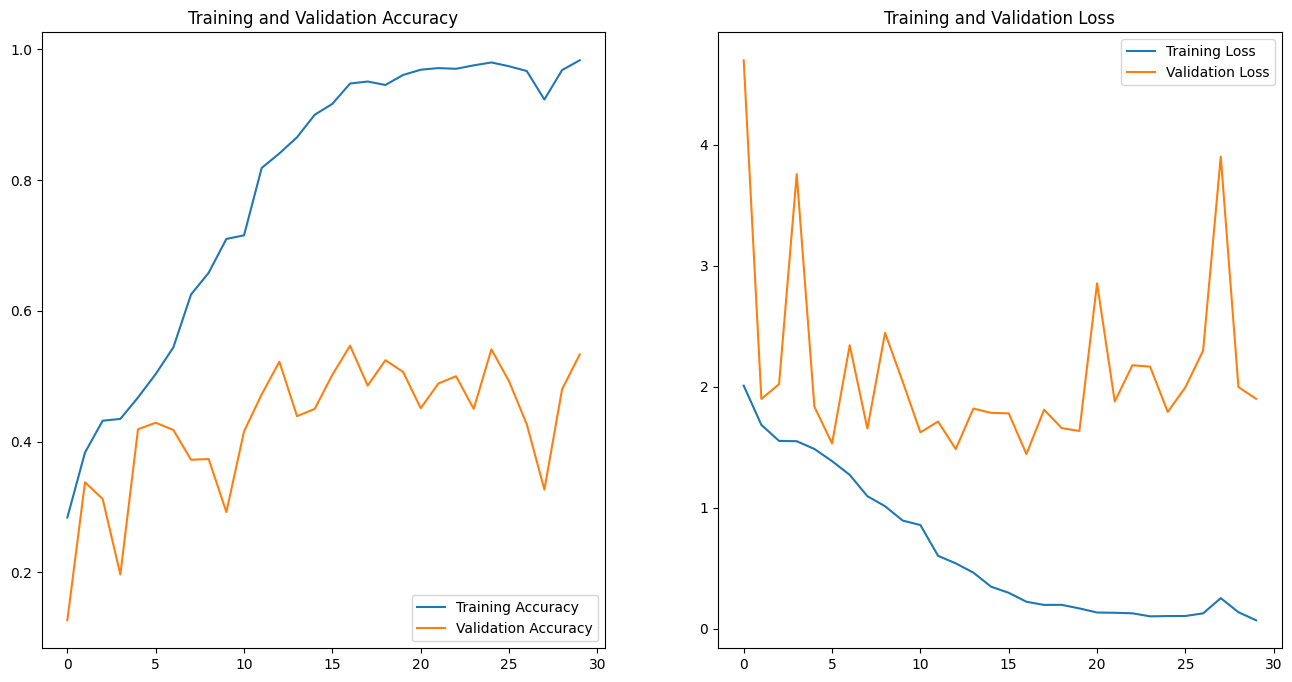

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

